# LP-GAN Training

This notebook demonstrates training an LP-GAN (Lp Gradient Penalty GAN) on various datasets like Shapes3D, Cars3D, and DSprites.

The LP-GAN uses Wasserstein loss with Lp gradient penalty to enforce the Lipschitz constraint on the discriminator, leading to more stable training compared to vanilla GANs. The gradient penalty typically uses L2 norm (p=2) but can be generalized to other Lp norms.

In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Add the project root to the path to import our modules
sys.path.append('jupyter NBs/GAN (Tests)')

# Import our custom modules
from datasets.shapes3d import Shapes3D
from gan.trainer import GANTrainer
from gan.architecture import Generator, Discriminator
from gan.loss import get_loss
from gan.utils import show_dataset_samples, free_memory, set_random_seeds

# Set up device and random seeds for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Memory cleanup utility - now using imported function from utils
# Example: call after training (you can also call manually later)
free_memory()

RAM and CUDA memory have been freed.


In [3]:
# Set random seeds for reproducibility - now using imported function from utils
seed_number = 42
set_random_seeds(seed_number)

Random seeds set to 42 for reproducibility.


# Shapes3D

In [4]:
# Dataset Configuration
print("Setting up Shapes3D dataset...")

# For this experiment, we'll allow all factors to vary
# This gives us the full diversity of the dataset
selected_factors = ['floorCol', 'wallCol', 'objCol', 'objSize', 'objType', 'objAzimuth']
not_selected_factors_index_value = {}  # Empty since we're selecting all factors

# root = '/data/amin/shapes3d/'  # Adjust this path as needed
root = 'data/shapes3d/'  # Local path for testing

# Create dataset instance
dataset = Shapes3D(
    selected_factors=selected_factors,
    not_selected_factors_index_value=not_selected_factors_index_value,
    root=root,
)

print(f"Dataset loaded with {len(dataset)} images")
print(f"Image size: {dataset.img_size}")
print(f"Selected factors: {dataset.selected_factors}")

# Create DataLoader
batch_size = 64
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=7 if device.type == 'cuda' else 0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"DataLoader created with batch size: {batch_size}")
print(f"Number of batches: {len(dataloader)}")

Setting up Shapes3D dataset...
Dataset loaded with 480000 images
Image size: (3, 64, 64)
Selected factors: ['floorCol', 'wallCol', 'objCol', 'objSize', 'objType', 'objAzimuth']
DataLoader created with batch size: 64
Number of batches: 7500


Sample images from the Shapes3D dataset:


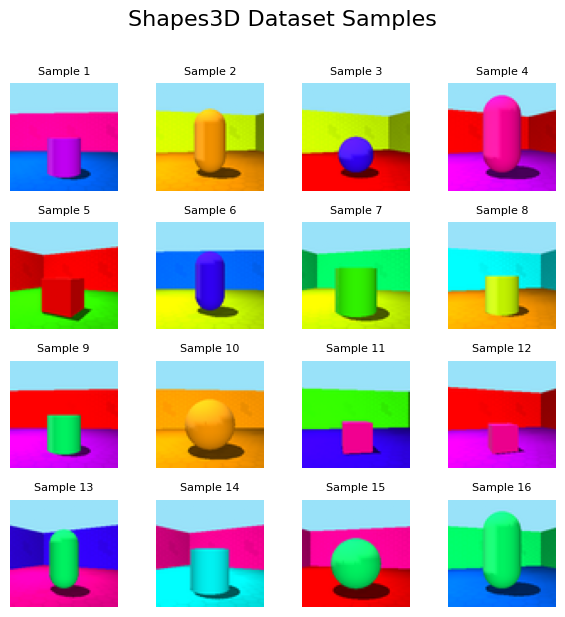

In [5]:
# Visualize some sample data
print("Sample images from the Shapes3D dataset:")
show_dataset_samples(dataset, n_samples=16, title='Shapes3D Dataset Samples')

In [22]:
# LP-GAN Configuration
print("Setting up LP-GAN trainer...")

# Model hyperparameters
latent_dim = 10
img_size = (3, 64, 64)  # C, H, W
learning_rate_g = 1e-4
learning_rate_d = 1e-4
beta1 = 0.5  # LP-GAN typically uses beta1=0.5 for Adam
beta2 = 0.999

# LP-GAN specific parameters
lambda_gp = 10.0  # Gradient penalty coefficient
p_norm = 2  # Order of Lp norm (L2 penalty)

# Create models explicitly (no more defaults inside GANTrainer)
generator = Generator(latent_dim=latent_dim, 
                      img_size=img_size, 
                      use_batchnorm=True, 
                      negative_slope=0, 
                      output_activation='sigmoid'
                      )
# LP-GAN doesn't require spectral normalization, uses gradient penalty instead
discriminator = Discriminator(img_size=img_size, 
                              use_spectral_norm=False,
                              negative_slope=0.1  # Optional, can be adjusted
                              )

# Move models to device
generator = generator.to(device)
discriminator = discriminator.to(device)

# Create optimizers explicitly
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate_g, betas=(beta1, beta2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate_d, betas=(beta1, beta2))

# Create LP-GAN trainer (now requires models and optimizers)
trainer = GANTrainer(
    generator=generator,
    discriminator=discriminator,
    g_optimizer=g_optimizer,
    d_optimizer=d_optimizer,
    loss_type='lpgan',  # Lp gradient penalty loss
    loss_kwargs={'lambda_gp': lambda_gp, 'p': p_norm},
    device=device,
    n_critic=1  # Update generator every discriminator update
)

print(f"LP-GAN trainer created")
print(f"Generator parameters: {sum(p.numel() for p in trainer.generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in trainer.discriminator.parameters()):,}")
print(f"Loss type: {trainer.loss_type}")
print(f"Gradient penalty coefficient (λ_gp): {lambda_gp}")
print(f"Lp norm order (p): {p_norm}")
print(f"Device: {trainer.device}")

Setting up LP-GAN trainer...
LP-GAN trainer created
Generator parameters: 382,723
Discriminator parameters: 379,073
Loss type: lpgan
Gradient penalty coefficient (λ_gp): 10.0
Lp norm order (p): 2
Device: cuda


In [23]:
# Training Configuration
epochs = 10  # Adjust based on your computational resources

# Option 1: Train by epochs (existing functionality)
trainer.train(dataloader, epochs=epochs)

# Option 2: Train by iterations (new functionality)
# You can also train by specifying total iterations instead of epochs
# This gives you precise control over training duration regardless of dataset size
# Example:
# total_iterations = epochs * len(dataloader)  # equivalent to the epochs above
# trainer.train(dataloader, total_iterations=total_iterations)
# 
# Or train for a specific number of iterations:
# trainer.train(dataloader, total_iterations=1000)  # train for exactly 1000 iterations

Training for 10 epochs (75000 iterations)...
Starting training for 75000 iterations...
Loss type: lpgan
Device: cuda
Log interval: 500 iterations


Training Iterations: 100%|██████████| 75000/75000 [32:23<00:00, 38.60it/s, D_loss=-3.0624, G_loss=-2.4823, Epoch=9.0]  


Training completed!


(-3.932019970435699, -2.8136327017633658)

Plotting training losses...


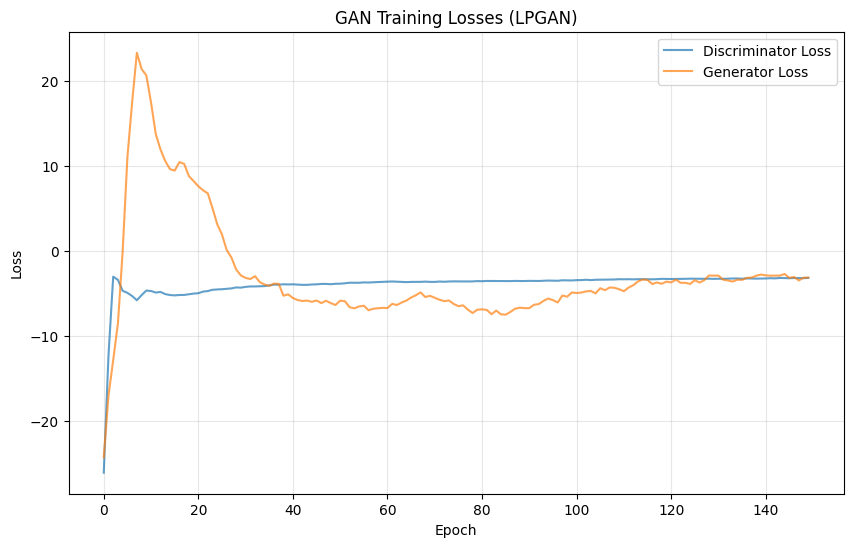


Training Summary:
Final Discriminator Loss: -3.1368
Final Generator Loss: -3.0888
Average Discriminator Loss: -3.9320
Average Generator Loss: -2.8136


In [25]:
# Visualize Training Progress
print("Plotting training losses...")
trainer.plot_losses()

# Show training history summary
if trainer.history['d_loss'] and trainer.history['g_loss']:
    print(f"\nTraining Summary:")
    print(f"Final Discriminator Loss: {trainer.history['d_loss'][-1]:.4f}")
    print(f"Final Generator Loss: {trainer.history['g_loss'][-1]:.4f}")
    print(f"Average Discriminator Loss: {np.mean(trainer.history['d_loss']):.4f}")
    print(f"Average Generator Loss: {np.mean(trainer.history['g_loss']):.4f}")

Generating sample images from trained LP-GAN...


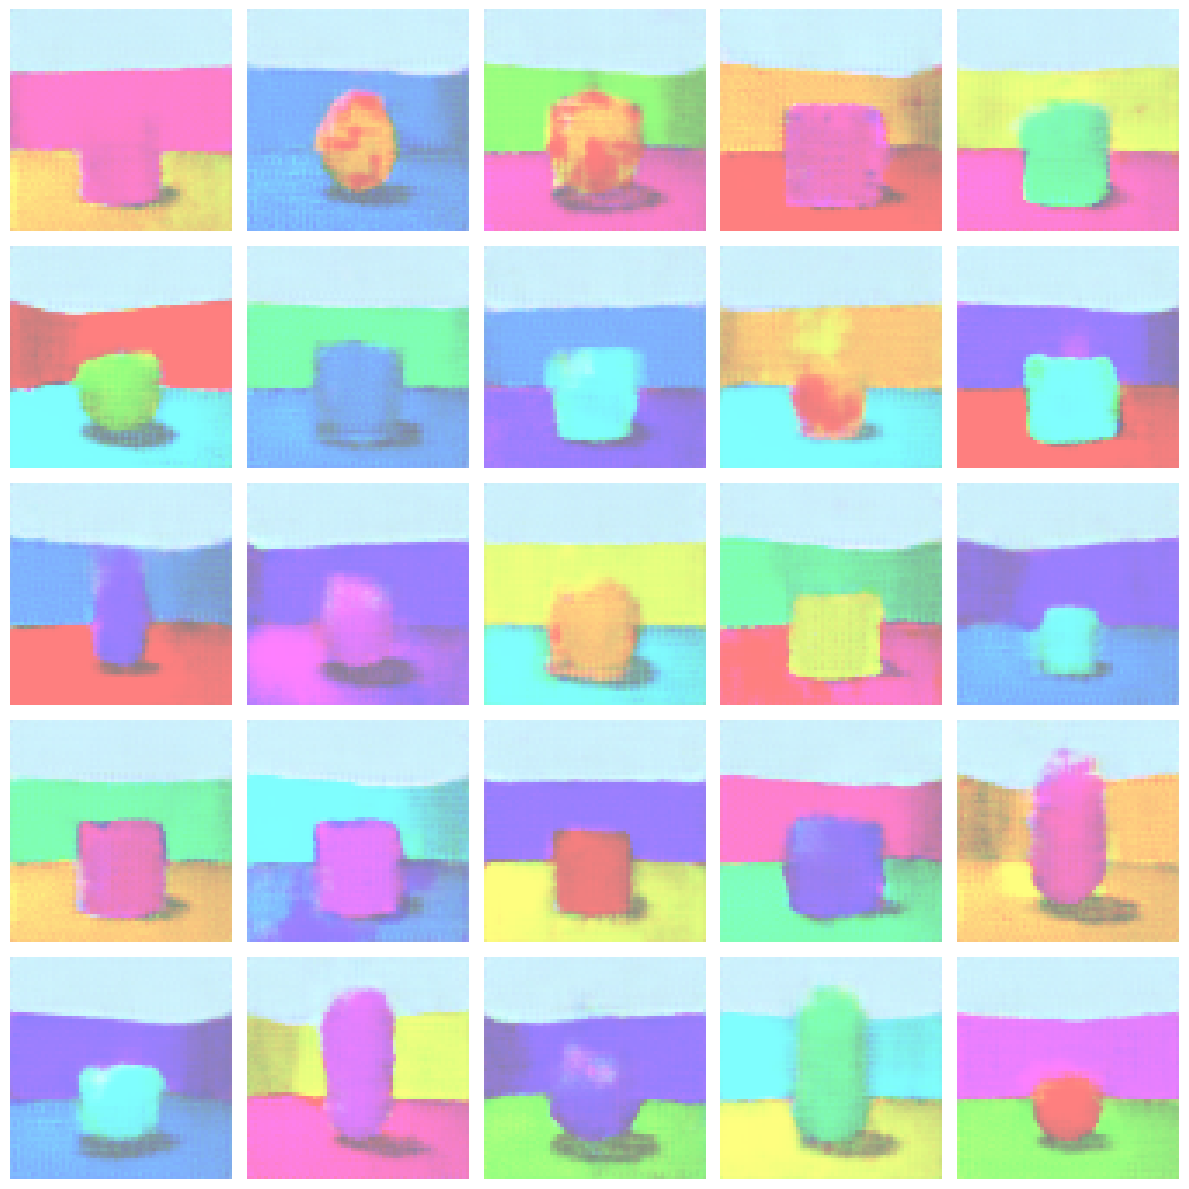

In [26]:
# Generate and Display Sample Images
print("Generating sample images from trained LP-GAN...")
trainer.plot_samples(n_samples=25, n_cols=5, figsize=(12, 12))

# DSprites

In [10]:
# Dataset Configuration for DSprites
print("Setting up DSprites dataset...")

# Import DSprites dataset
from datasets.dsprites import DSprites

# For dsprites, we'll select all factors except color (which has only one value)
# DSprites factors: ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
# selected_factors = ['shape', 'scale', 'orientation', 'posX', 'posY']
# not_selected_factors_index_value = {'color': 0}  # Fix color to its only value

selected_factors = ['orientation', 'posX', 'posY']  # Example selection for dsprites
not_selected_factors_index_value = {'color': 0, 'shape':0, 'scale': 5}  


root = 'data/dsprites/'  # Local path for dsprites dataset

# Create dataset instance
dataset_dsprites = DSprites(
    selected_factors=selected_factors,
    not_selected_factors_index_value=not_selected_factors_index_value,
    root=root,
    drop_color_factor=True  # Drop color factor since it has only one value
)

print(f"DSprites dataset loaded with {len(dataset_dsprites)} images")
print(f"Image size: {dataset_dsprites.img_size}")
print(f"Selected factors: {dataset_dsprites.selected_factors}")

# Create DataLoader
batch_size_dsprites = 64
dataloader_dsprites = DataLoader(
    dataset_dsprites, 
    batch_size=batch_size_dsprites, 
    shuffle=True, 
    num_workers=7 if device.type == 'cuda' else 0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"DataLoader created with batch size: {batch_size_dsprites}")
print(f"Number of batches: {len(dataloader_dsprites)}")

Setting up DSprites dataset...
DSprites dataset loaded with 40960 images
Image size: (1, 64, 64)
Selected factors: ['orientation', 'posX', 'posY']
DataLoader created with batch size: 64
Number of batches: 640


Sample images from the DSprites dataset:


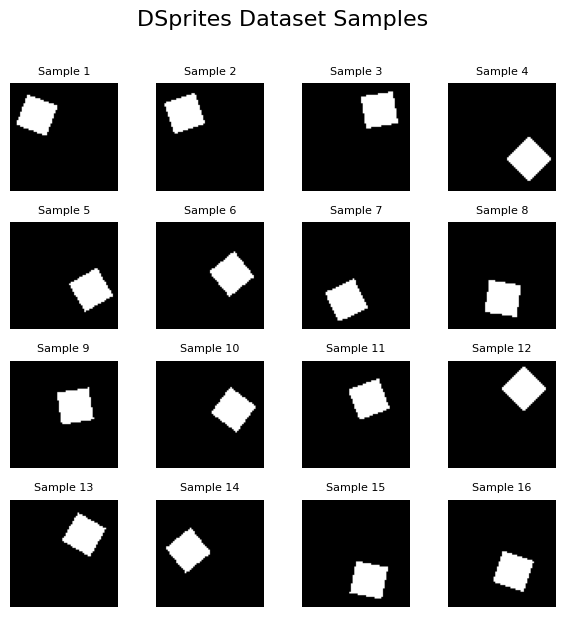

In [11]:
# Visualize some sample data from DSprites
print("Sample images from the DSprites dataset:")
show_dataset_samples(dataset_dsprites, n_samples=16, title='DSprites Dataset Samples')

In [12]:
# LP-GAN Configuration for DSprites
print("Setting up LP-GAN trainer for DSprites...")

# Model hyperparameters for DSprites (grayscale images)
latent_dim_dsprites = 10
img_size_dsprites = (1, 64, 64)  # Grayscale images (1 channel)
learning_rate_g_dsprites = 1e-4
learning_rate_d_dsprites = 1e-4
beta1_dsprites = 0.5  # LP-GAN typically uses beta1=0.5
beta2_dsprites = 0.999

# LP-GAN specific parameters
lambda_gp_dsprites = 10.0  # Gradient penalty coefficient
p_norm_dsprites = 2  # Order of Lp norm (L2 penalty)

# Create models for DSprites (1-channel input)
generator_dsprites = Generator(latent_dim=latent_dim_dsprites, img_size=img_size_dsprites, output_activation='sigmoid')
# LP-GAN doesn't require spectral normalization, uses gradient penalty instead
discriminator_dsprites = Discriminator(img_size=img_size_dsprites, use_spectral_norm=False)

# Move models to device
generator_dsprites = generator_dsprites.to(device)
discriminator_dsprites = discriminator_dsprites.to(device)

# Create optimizers
g_optimizer_dsprites = optim.Adam(generator_dsprites.parameters(), lr=learning_rate_g_dsprites, betas=(beta1_dsprites, beta2_dsprites))
d_optimizer_dsprites = optim.Adam(discriminator_dsprites.parameters(), lr=learning_rate_d_dsprites, betas=(beta1_dsprites, beta2_dsprites))

# Create LP-GAN trainer for DSprites
trainer_dsprites = GANTrainer(
    generator=generator_dsprites,
    discriminator=discriminator_dsprites,
    g_optimizer=g_optimizer_dsprites,
    d_optimizer=d_optimizer_dsprites,
    loss_type='lpgan',  # Lp gradient penalty loss
    loss_kwargs={'lambda_gp': lambda_gp_dsprites, 'p': p_norm_dsprites},
    device=device,
    n_critic=1  # Update generator every discriminator update
)

print(f"LP-GAN trainer created for DSprites")
print(f"Generator parameters: {sum(p.numel() for p in trainer_dsprites.generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in trainer_dsprites.discriminator.parameters()):,}")
print(f"Loss type: {trainer_dsprites.loss_type}")
print(f"Gradient penalty coefficient (λ_gp): {lambda_gp_dsprites}")
print(f"Lp norm order (p): {p_norm_dsprites}")
print(f"Device: {trainer_dsprites.device}")
print(f"Image size: {img_size_dsprites}")

Setting up LP-GAN trainer for DSprites...
LP-GAN trainer created for DSprites
Generator parameters: 381,697
Discriminator parameters: 378,049
Loss type: lpgan
Gradient penalty coefficient (λ_gp): 10.0
Lp norm order (p): 2
Device: cuda
Image size: (1, 64, 64)


In [13]:
# Training Configuration for DSprites
epochs_dsprites = 10  # Adjust based on your computational resources
print(f"Starting LP-GAN training on DSprites for {epochs_dsprites} epochs...")

# Option 1: Train by epochs (existing functionality)
trainer_dsprites.train(dataloader_dsprites, epochs=epochs_dsprites)

# Option 2: Train by iterations (new functionality)
# Alternative approach - train by specifying total iterations
# total_iterations = epochs_dsprites * len(dataloader_dsprites)
# trainer_dsprites.train(dataloader_dsprites, total_iterations=total_iterations)
#
# Or train for a fixed number of iterations regardless of dataset size:
# trainer_dsprites.train(dataloader_dsprites, total_iterations=5000)
#
# You can also specify custom log intervals for iteration-based training:
# trainer_dsprites.train(dataloader_dsprites, total_iterations=5000, log_interval=500)

print("DSprites training completed!")

Starting LP-GAN training on DSprites for 10 epochs...
Training for 10 epochs (6400 iterations)...
Starting training for 6400 iterations...
Loss type: lpgan
Device: cuda
Log interval: 500 iterations


Training Iterations: 100%|██████████| 6400/6400 [02:06<00:00, 50.78it/s, D_loss=-0.6448, G_loss=-70.0449, Epoch=9.0]  


Training completed!
DSprites training completed!


Plotting DSprites training losses...


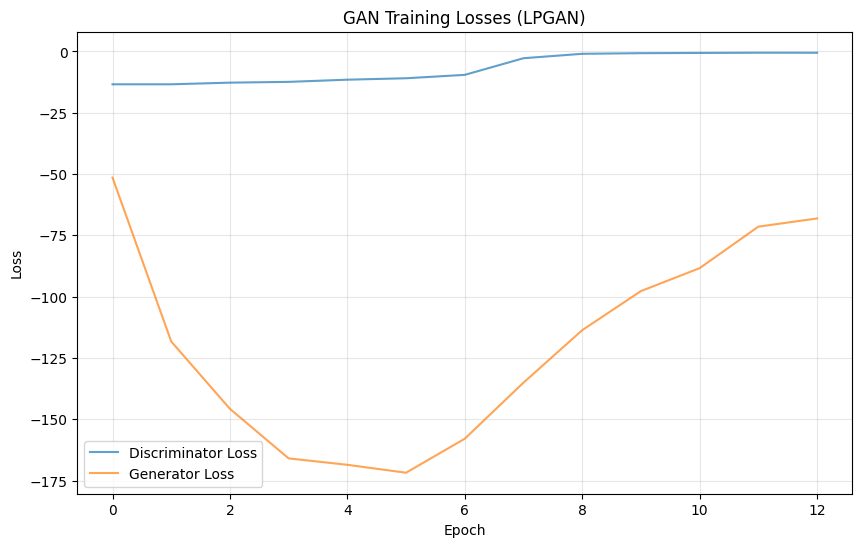


DSprites Training Summary:
Final Discriminator Loss: -0.5544
Final Generator Loss: -68.1072
Average Discriminator Loss: -6.9444
Average Generator Loss: -119.5279


In [14]:
# Visualize DSprites Training Progress
print("Plotting DSprites training losses...")
trainer_dsprites.plot_losses()

# Show training history summary for DSprites
if trainer_dsprites.history['d_loss'] and trainer_dsprites.history['g_loss']:
    print(f"\nDSprites Training Summary:")
    print(f"Final Discriminator Loss: {trainer_dsprites.history['d_loss'][-1]:.4f}")
    print(f"Final Generator Loss: {trainer_dsprites.history['g_loss'][-1]:.4f}")
    print(f"Average Discriminator Loss: {np.mean(trainer_dsprites.history['d_loss']):.4f}")
    print(f"Average Generator Loss: {np.mean(trainer_dsprites.history['g_loss']):.4f}")

Generating sample images from trained LP-GAN on DSprites...


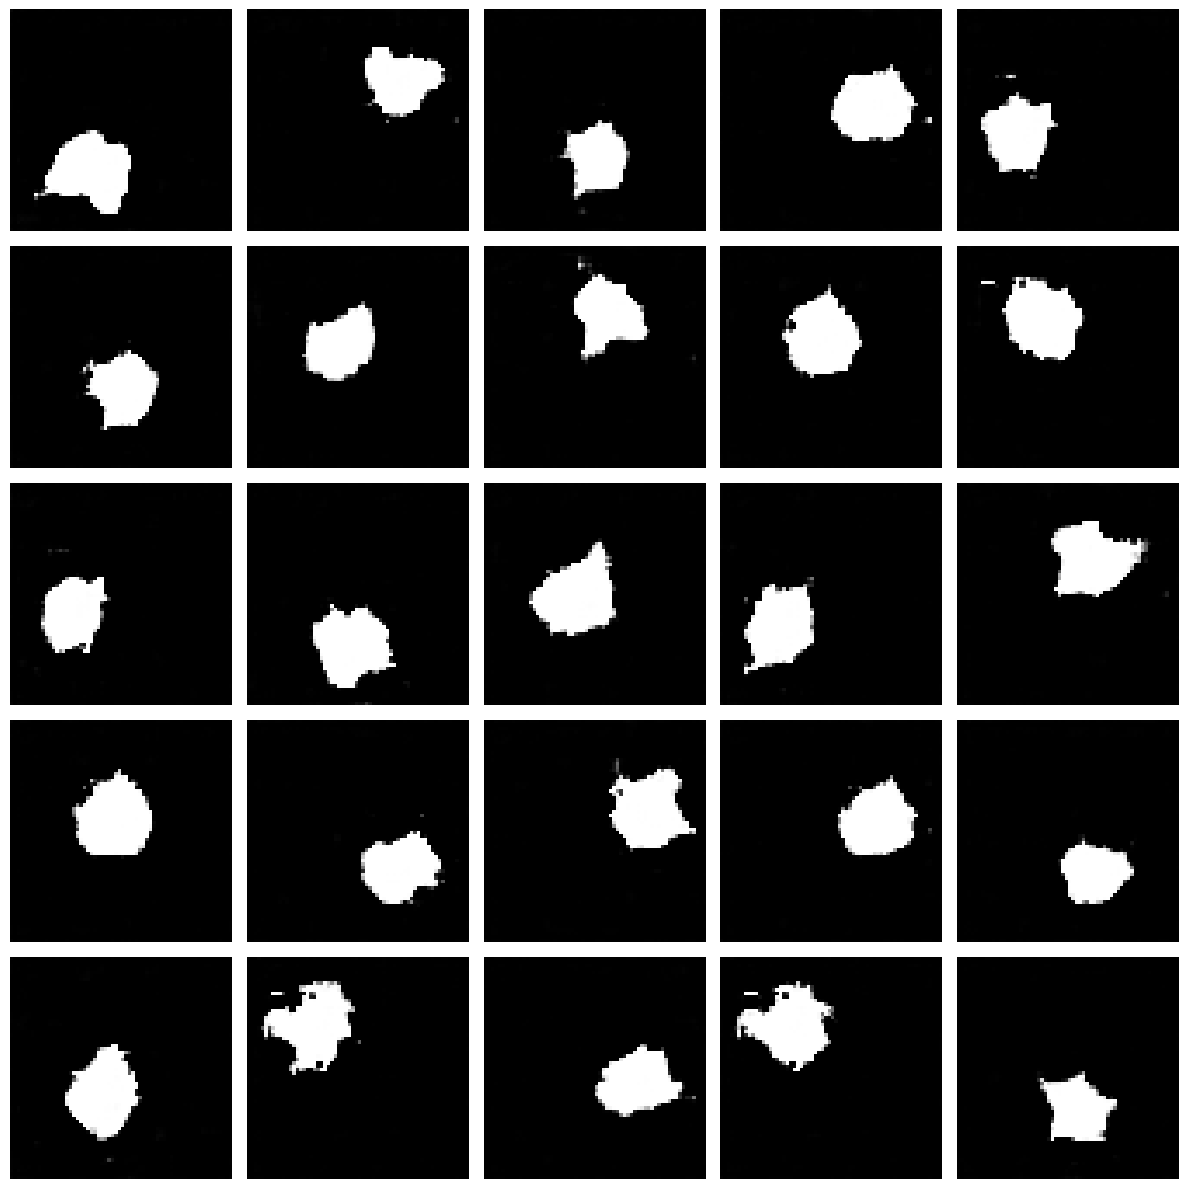

In [15]:
# Generate and Display Sample Images from DSprites LP-GAN
print("Generating sample images from trained LP-GAN on DSprites...")
trainer_dsprites.plot_samples(n_samples=25, n_cols=5, figsize=(12, 12))

# Cars3D

In [16]:
# Dataset Configuration for Cars3D
print("Setting up Cars3D dataset...")

# Import Cars3D dataset
from datasets.cars3d import Cars3D

# For Cars3D, we'll select all factors to show the full diversity
# Cars3D factors: ('elevation', 'azimuth', 'object_type')
selected_factors = ['elevation', 'azimuth', 'object_type']
not_selected_factors_index_value = {}  # Empty since we're selecting all factors

root = 'data/cars3d/'  # Local path for cars3d dataset

# Create dataset instance
dataset_cars3d = Cars3D(
    selected_factors=selected_factors,
    not_selected_factors_index_value=not_selected_factors_index_value,
    root=root,
)

print(f"Cars3D dataset loaded with {len(dataset_cars3d)} images")
print(f"Image size: {dataset_cars3d.img_size}")
print(f"Selected factors: {dataset_cars3d.selected_factors}")

# Create DataLoader
batch_size_cars3d = 64
dataloader_cars3d = DataLoader(
    dataset_cars3d, 
    batch_size=batch_size_cars3d, 
    shuffle=True, 
    num_workers=7 if device.type == 'cuda' else 0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"DataLoader created with batch size: {batch_size_cars3d}")
print(f"Number of batches: {len(dataloader_cars3d)}")

Setting up Cars3D dataset...
Cars3D dataset loaded with 17568 images
Image size: (3, 64, 64)
Selected factors: ['elevation', 'azimuth', 'object_type']
DataLoader created with batch size: 64
Number of batches: 275


Sample images from the Cars3D dataset:


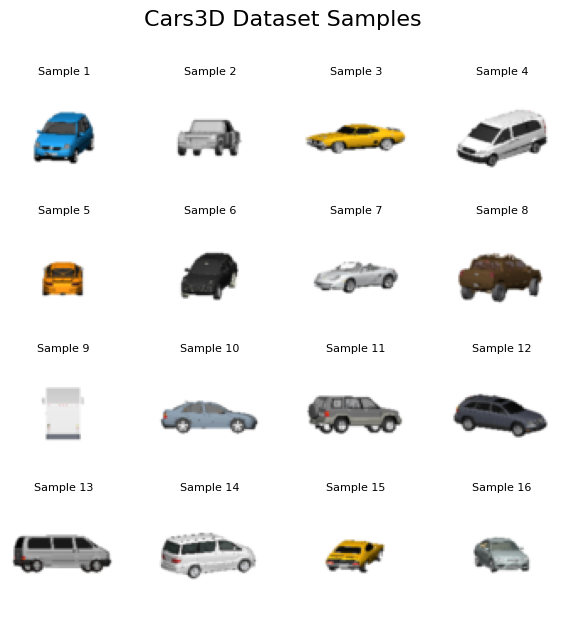

In [17]:
# Visualize some sample data from Cars3D
print("Sample images from the Cars3D dataset:")
show_dataset_samples(dataset_cars3d, n_samples=16, title='Cars3D Dataset Samples')

In [18]:
# LP-GAN Configuration for Cars3D
print("Setting up LP-GAN trainer for Cars3D...")

# Model hyperparameters for Cars3D (RGB images, same as Shapes3D)
latent_dim_cars3d = 10
img_size_cars3d = (3, 64, 64)  # RGB images (3 channels)
learning_rate_g_cars3d = 1e-4
learning_rate_d_cars3d = 1e-4
beta1_cars3d = 0.5  # LP-GAN typically uses beta1=0.5
beta2_cars3d = 0.999

# LP-GAN specific parameters
lambda_gp_cars3d = 10.0  # Gradient penalty coefficient
p_norm_cars3d = 2  # Order of Lp norm (L2 penalty)

# Create models for Cars3D (3-channel RGB input, same as Shapes3D)
generator_cars3d = Generator(latent_dim=latent_dim_cars3d, img_size=img_size_cars3d, use_batchnorm=True, negative_slope=0.2, output_activation='sigmoid')
# LP-GAN doesn't require spectral normalization, uses gradient penalty instead
discriminator_cars3d = Discriminator(img_size=img_size_cars3d, use_spectral_norm=False)

# Move models to device
generator_cars3d = generator_cars3d.to(device)
discriminator_cars3d = discriminator_cars3d.to(device)

# Create optimizers
g_optimizer_cars3d = optim.Adam(generator_cars3d.parameters(), lr=learning_rate_g_cars3d, betas=(beta1_cars3d, beta2_cars3d))
d_optimizer_cars3d = optim.Adam(discriminator_cars3d.parameters(), lr=learning_rate_d_cars3d, betas=(beta1_cars3d, beta2_cars3d))

# Create LP-GAN trainer for Cars3D
trainer_cars3d = GANTrainer(
    generator=generator_cars3d,
    discriminator=discriminator_cars3d,
    g_optimizer=g_optimizer_cars3d,
    d_optimizer=d_optimizer_cars3d,
    loss_type='lpgan',  # Lp gradient penalty loss
    loss_kwargs={'lambda_gp': lambda_gp_cars3d, 'p': p_norm_cars3d},
    device=device,
    n_critic=1  # Update generator every discriminator update
)

print(f"LP-GAN trainer created for Cars3D")
print(f"Generator parameters: {sum(p.numel() for p in trainer_cars3d.generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in trainer_cars3d.discriminator.parameters()):,}")
print(f"Loss type: {trainer_cars3d.loss_type}")
print(f"Gradient penalty coefficient (λ_gp): {lambda_gp_cars3d}")
print(f"Lp norm order (p): {p_norm_cars3d}")
print(f"Device: {trainer_cars3d.device}")
print(f"Image size: {img_size_cars3d}")

Setting up LP-GAN trainer for Cars3D...
LP-GAN trainer created for Cars3D
Generator parameters: 382,723
Discriminator parameters: 379,073
Loss type: lpgan
Gradient penalty coefficient (λ_gp): 10.0
Lp norm order (p): 2
Device: cuda
Image size: (3, 64, 64)


In [19]:
# Training Configuration for Cars3D
epochs_cars3d = 100  # Adjust based on your computational resources
print(f"Starting LP-GAN training on Cars3D for {epochs_cars3d} epochs...")

# Option 1: Train by epochs (existing functionality)
trainer_cars3d.train(dataloader_cars3d, epochs=epochs_cars3d)

# Option 2: Train by iterations (new functionality)
# Alternative approach - train by specifying total iterations
# total_iterations = epochs_cars3d * len(dataloader_cars3d)
# trainer_cars3d.train(dataloader_cars3d, total_iterations=total_iterations)
#
# Or train for a fixed number of iterations regardless of dataset size:
# trainer_cars3d.train(dataloader_cars3d, total_iterations=5000)
#
# You can also specify custom log intervals for iteration-based training:
# trainer_cars3d.train(dataloader_cars3d, total_iterations=5000, log_interval=500)

print("Cars3D training completed!")

Starting LP-GAN training on Cars3D for 100 epochs...
Training for 100 epochs (27500 iterations)...
Starting training for 27500 iterations...
Loss type: lpgan
Device: cuda
Log interval: 500 iterations


Training Iterations: 100%|██████████| 27500/27500 [10:27<00:00, 43.81it/s, D_loss=-0.1493, G_loss=-21.3158, Epoch=99.0]


Training completed!
Cars3D training completed!


Plotting Cars3D training losses...


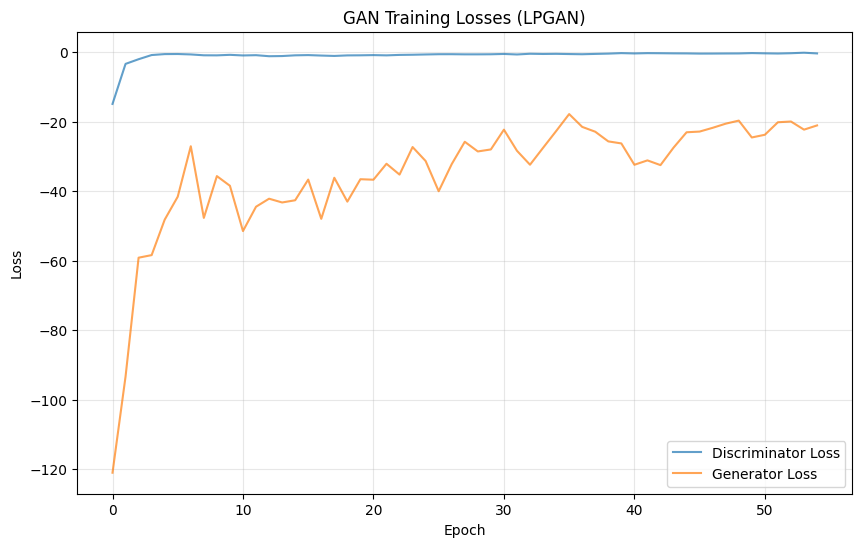


Cars3D Training Summary:
Final Discriminator Loss: -0.3206
Final Generator Loss: -21.0579
Average Discriminator Loss: -0.9099
Average Generator Loss: -34.9497


In [20]:
# Visualize Cars3D Training Progress
print("Plotting Cars3D training losses...")
trainer_cars3d.plot_losses()

# Show training history summary for Cars3D
if trainer_cars3d.history['d_loss'] and trainer_cars3d.history['g_loss']:
    print(f"\nCars3D Training Summary:")
    print(f"Final Discriminator Loss: {trainer_cars3d.history['d_loss'][-1]:.4f}")
    print(f"Final Generator Loss: {trainer_cars3d.history['g_loss'][-1]:.4f}")
    print(f"Average Discriminator Loss: {np.mean(trainer_cars3d.history['d_loss']):.4f}")
    print(f"Average Generator Loss: {np.mean(trainer_cars3d.history['g_loss']):.4f}")

Generating sample images from trained LP-GAN on Cars3D...


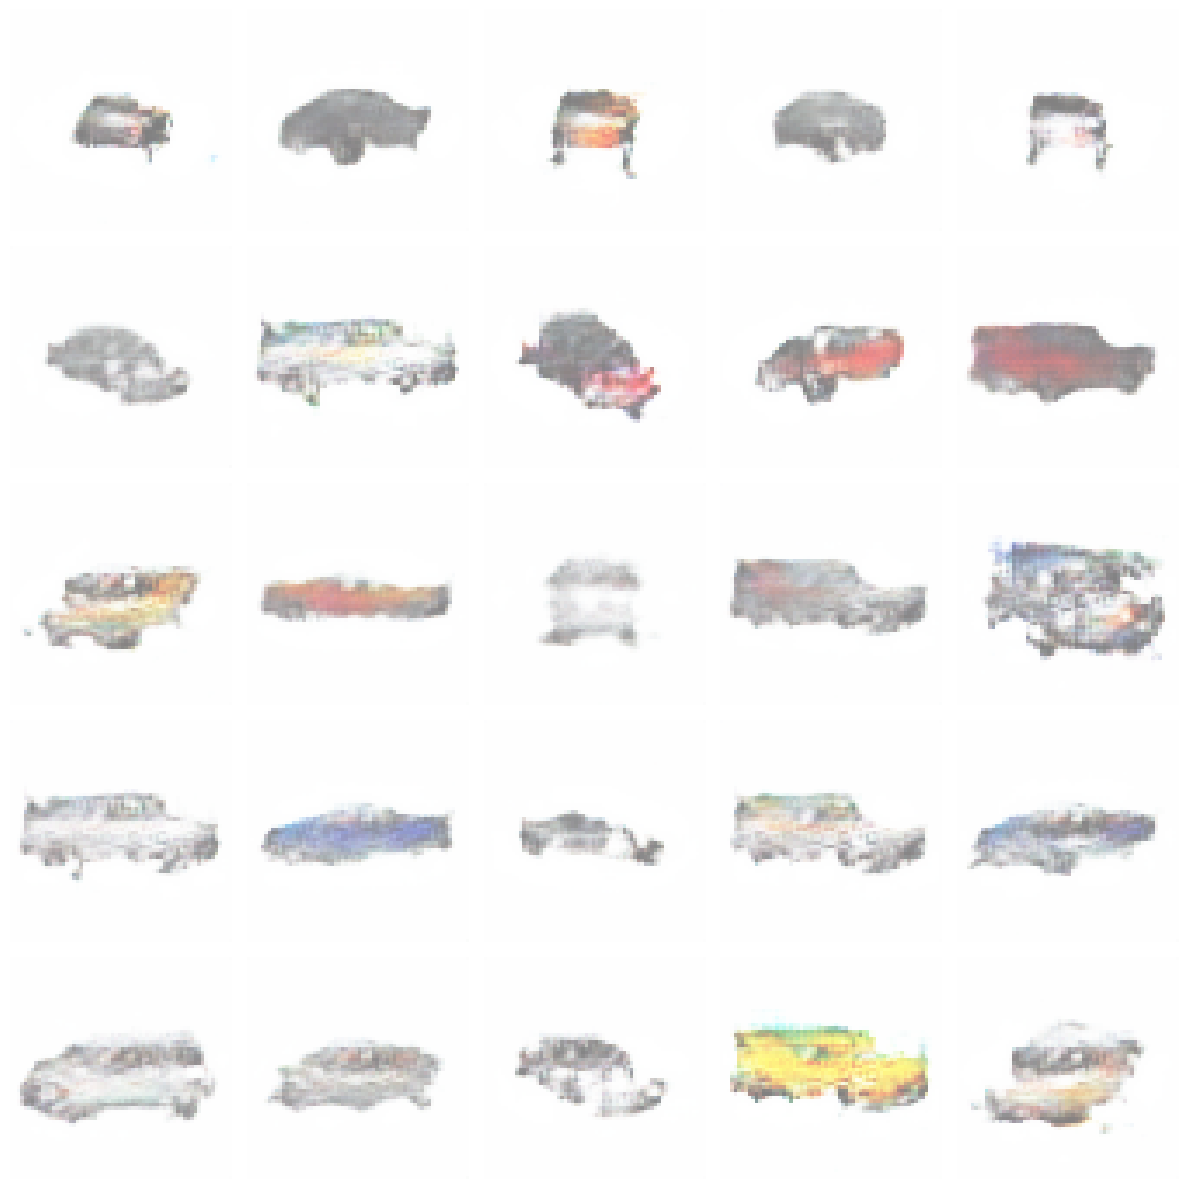

In [21]:
# Generate and Display Sample Images from Cars3D LP-GAN
print("Generating sample images from trained LP-GAN on Cars3D...")
trainer_cars3d.plot_samples(n_samples=25, n_cols=5, figsize=(12, 12))